### This Notebook takes the previously created BC ignoring the NEMO Levels and JP practical salinity and does the vertical interpolation and gsw calls to generate proper salinity to write them into final input BC file one for each boundary

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from salishsea_tools import (nc_tools, gsw_calls,viz_tools)
from fancyimpute import KNN

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


##### Import the mesh_mask.nc for the depth levels on which to interpolate our values (We will use the mask recently created with 27 depth levels after playing with the NEMO parameters)

In [3]:
mask = nc.Dataset('/ocean/ssahu/CANYONS/Runs/trial_run_mesh_mask_gen/mesh_mask.nc')

#mask = nc.Dataset('/ocean/ssahu/CANYONS/Results/Westcoast_attempt17_generate_mask_80_levels/mesh_mask.nc')

NEMO_depth_T = mask.variables['nav_lev'][:];

print(NEMO_depth_T.shape)

(27,)


In [4]:
NEMO_depth_T

array([   14.75075722,    24.42877769,    34.46412659,    45.19285583,
          57.26233673,    71.90678406,    91.43279266,   119.99002075,
         164.52903748,   235.26014709,   344.00537109,   499.3053894 ,
         701.16015625,   941.02905273,  1207.08996582,  1489.1328125 ,
        1780.20678711,  2076.16235352,  2374.69287109,  2674.56420898,
        2975.12866211,  3276.05078125,  3577.15649414,  3878.35668945,
        4179.60546875,  4480.87939453,  4782.16601562], dtype=float32)

#### Let us start with the left boundary (West)

##### The 2D output BC fields are fine so we donot need to worry about them and they have been properly created by the previous notebook (Writing_bdy_files) but the fields inside the 3d boundary files have not been interpolated and the salinity values need to be converted to absolute salinity from PSU

In [30]:
left_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/3d_west_m04.nc');

vosaline_JP_level_PSU_left = left_file.variables['vosaline'][:];
votemper_JP_level_PT_left = left_file.variables['votemper'][:];
U_vel_JP_level_left = left_file.variables['vozocrtx'][:];
V_vel_JP_level_left = left_file.variables['vomecrty'][:];


print(vosaline_JP_level_PSU_left.shape, votemper_JP_level_PT_left.shape, U_vel_JP_level_left.shape, V_vel_JP_level_left.shape)

(43, 50, 4, 100) (43, 50, 4, 100) (43, 50, 4, 100) (43, 50, 4, 100)


#### Our boundary files donot have a depth variable from which we can import the depths but the files created before the vertical interpolation of the IC values have the depth variable (the file is called West_coast_temperature_salinity_nomask_JP.nc)

In [6]:
depth_JP_T = nc.Dataset('/home/ssahu/saurav/JP_BC/cat_42_days_T.nc').variables['deptht'][:];

In [7]:
lat = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/initial_conditions/West_coast_temperature_salinity_nomask_JP.nc')\
            .variables['nav_lat'][:];
lon = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/initial_conditions/West_coast_temperature_salinity_nomask_JP.nc')\
            .variables['nav_lon'][:]
print(depth_JP_T.shape, lat.shape)

# Conversion of vosaline_PSU to vosaline_RS and votemper_PT to votemper_CT

z = np.dot(-1,depth_JP_T);

(50,) (100, 70)


In [10]:
pressure = np.empty(z.shape);
lats = np.empty(pressure.shape);
lons = np.empty(pressure.shape);
lats[:] = np.mean(lat);
lons[:] = np.mean(lon);

In [31]:
vosaline_JP_level_SA_left = np.empty(vosaline_JP_level_PSU_left.shape);
vosaline_JP_level_RS_left = np.empty(vosaline_JP_level_PSU_left.shape);
votemper_JP_level_CT_left = np.empty(vosaline_JP_level_PSU_left.shape);

pressure = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z, np.mean(lat)]);
for i,j in enumerate(vosaline_JP_level_SA_left[0,:,...]):
    vosaline_JP_level_SA_left[:,i,...] = gsw_calls.generic_gsw_caller('gsw_SA_from_SP', [vosaline_JP_level_PSU_left[:,i,...],pressure[i],lons[i],lats[i]]);

vosaline_JP_level_RS_left[:] = gsw_calls.generic_gsw_caller('gsw_SR_from_SP', [vosaline_JP_level_PSU_left[:]]);
votemper_JP_level_CT_left[:] = gsw_calls.generic_gsw_caller('gsw_CT_from_pt', [vosaline_JP_level_SA_left[:], votemper_JP_level_PT_left[:]]);

In [7]:
# vosaline_JP_level_RS_left[vosaline_JP_level_RS_left == []] = ['Nan'];
# votemper_JP_level_CT_left[votemper_JP_level_CT_left == []] = ['Nan'];

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


In [32]:
np.min(vosaline_JP_level_RS_left)

nan

In [33]:
vosaline_JP_level_RS_left.shape, U_vel_JP_level_left.shape

((43, 50, 4, 100), (43, 50, 4, 100))

#### Now let us fill up the holes before going doing the vertical interpolation

In [42]:
# try:
#     for p,q in enumerate(vosaline_JP_level_RS_left[:,...]):
#         for i,j in enumerate(vosaline_JP_level_RS_left[p,:,...]):
#             votemper_JP_level_CT_left[p,i,...] = KNN(k=3).complete(votemper_JP_level_CT_left[p,i,...]);
#             vosaline_JP_level_RS_left[p,i,...] = KNN(k=3).complete(vosaline_JP_level_RS_left[p,i,...]);
#             U_vel_JP_level_left[p,i,...] = KNN(k=3).complete(U_vel_JP_level_left[p,i,...]);
#             V_vel_JP_level_left[p,i,...] = KNN(k=3).complete(V_vel_JP_level_left[p,i,...]);
# except:
#     pass



# for a,b in enumerate(vosaline_JP_level_RS_left[:,...]):
#     for i,j in enumerate(vosaline_JP_level_RS_left[a,:,...]):
#         for p,q in enumerate(vosaline_JP_level_RS_left[a,i,:,...]):
#             for l,m in enumerate(vosaline_JP_level_RS_left[a,i,p,:]):
#                 if np.isnan(vosaline_JP_level_RS_left[a,i,p,l]):
#                     vosaline_JP_level_RS_left[a,i,p,l] = vosaline_JP_level_RS_left[a,i-1,p,l]
#                 else:
#                     continue
#                 if np.isnan(votemper_JP_level_CT_left[a,i,p,l]):
#                     votemper_JP_level_CT_left[a,i,p,l] = votemper_JP_level_CT_left[a,i-1,p,l]
#                 else:
#                     continue
#                 if np.isnan(U_vel_JP_level_left[a,i,p,l]):
#                     U_vel_JP_level_left[a,i,p,l] = U_vel_JP_level_left[a,i-1,p,l]
#                 else:
#                     continue
#                 if np.isnan(V_vel_JP_level_left[a,i,p,l]):
#                     V_vel_JP_level_left[a,i,p,l] = V_vel_JP_level_left[a,i-1,p,l]
#                 else:
#                     continue

# for a in range(vosaline_JP_level_RS_left.shape[0]):
#     for i in range(10,vosaline_JP_level_RS_left.shape[1]):
#         for p in range(vosaline_JP_level_RS_left.shape[2]):
#             for q in range(vosaline_JP_level_RS_left.shape[3]):
#                 if vosaline_JP_level_RS_left[a,i,p,q] < vosaline_JP_level_RS_left[a,i-1,p,q]:
#                     vosaline_JP_level_RS_left[a,i,p,q] = vosaline_JP_level_RS_left[a,i-1,p,q]
#                 else:
#                     continue                    


# votemper_JP_level_CT_left[np.where(np.isnan(votemper_JP_level_CT_left))]=0;
# vosaline_JP_level_RS_left[np.where(np.isnan(vosaline_JP_level_RS_left))]=0;
# U_vel_JP_level_left[np.where(np.isnan(U_vel_JP_level_left))]=0;
# V_vel_JP_level_left[np.where(np.isnan(V_vel_JP_level_left))]=0;

# for a,b in enumerate(vosaline_JP_level_RS_left[:,...]):
#     for i,j in enumerate(vosaline_JP_level_RS_left[a,:,...]):
#         for p,q in enumerate(vosaline_JP_level_RS_left[a,i,:,...]):
#             for l,m in enumerate(vosaline_JP_level_RS_left[a,i,p,:]):
#                 if vosaline_JP_level_RS_left[a,i,p,l] == 0:
#                     vosaline_JP_level_RS_left[a,i,p,l] = vosaline_JP_level_RS_left[a,i-1,p,l]
#                 else:
#                     continue
#                 if votemper_JP_level_CT_left[a,i,p,l] == 0:
#                     votemper_JP_level_CT_left[a,i,p,l] = votemper_JP_level_CT_left[a,i-1,p,l]
#                 else:
#                     continue
#                 if U_vel_JP_level_left[a,i,p,l] == 0:
#                     U_vel_JP_level_left[a,i,p,l] = U_vel_JP_level_left[a,i-1,p,l]
#                 else:
#                     continue
#                 if V_vel_JP_level_left[a,i,p,l] == 0:
#                     V_vel_JP_level_left[a,i,p,l] = V_vel_JP_level_left[a,i-1,p,l]
#                 else:
#                     continue


                    
                    



#### let us interp1d to make a vertical function for each of these variables and then interpolate them to the values vertically

left_temp_function = interp1d(depth_JP_T, votemper_JP_level_CT_left, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
left_sal_function = interp1d(depth_JP_T, vosaline_JP_level_RS_left, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
left_U_function = interp1d(depth_JP_T, U_vel_JP_level_left, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
left_V_function = interp1d(depth_JP_T, V_vel_JP_level_left, axis=1,\
                              bounds_error=False, fill_value='extrapolate');

votemper_NEMO_left = np.empty((vosaline_JP_level_SA_left.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_left.shape[2], vosaline_JP_level_SA_left.shape[3]));
vosaline_NEMO_left = np.empty((vosaline_JP_level_SA_left.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_left.shape[2], vosaline_JP_level_SA_left.shape[3]));
U_NEMO_left = np.empty((vosaline_JP_level_SA_left.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_left.shape[2], vosaline_JP_level_SA_left.shape[3]));
V_NEMO_left = np.empty((vosaline_JP_level_SA_left.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_left.shape[2], vosaline_JP_level_SA_left.shape[3]));


for indx in np.arange(NEMO_depth_T.shape[0]):
    votemper_NEMO_left[:,indx,...] = left_temp_function(NEMO_depth_T[indx]);
    vosaline_NEMO_left[:,indx,...] = left_sal_function(NEMO_depth_T[indx]);
    U_NEMO_left[:,indx,...]        = left_U_function(NEMO_depth_T[indx]);
    V_NEMO_left[:,indx,...]        = left_V_function(NEMO_depth_T[indx]);
    



print(votemper_NEMO_left.shape, vosaline_NEMO_left.shape, U_NEMO_left.shape, V_NEMO_left.shape)

(43, 27, 4, 100) (43, 27, 4, 100) (43, 27, 4, 100) (43, 27, 4, 100)


In [43]:
for i in np.arange(vosaline_NEMO_left.shape[0]):
    for j in np.arange(vosaline_NEMO_left.shape[1]):
        for k in np.arange(vosaline_NEMO_left.shape[2]):
            for l in np.arange(vosaline_NEMO_left.shape[3]):
                if np.isnan(vosaline_NEMO_left[i,j,k,l]):
                    vosaline_NEMO_left[i,j,k,l] = vosaline_NEMO_left[i,j-1,k,l]
                else:
                    continue
            

for i in np.arange(votemper_NEMO_left.shape[0]):
    for j in np.arange(votemper_NEMO_left.shape[1]):
        for k in np.arange(votemper_NEMO_left.shape[2]):
            for l in np.arange(votemper_NEMO_left.shape[3]):
                if np.isnan(votemper_NEMO_left[i,j,k,l]):
                    votemper_NEMO_left[i,j,k,l] = votemper_NEMO_left[i,j-1,k,l]
                else:
                    continue   

In [44]:
np.where(np.isnan(vosaline_NEMO_left[...]))

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

#### Now we will take the values from the created nc file of initial conditions to make the BC same as the ic file for the first time step

ic_file = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/initial_conditions/West_coast_NEMO_IC_temperature_salinity_nomask_JP.nc');

ic_temp = ic_file.variables['votemper'][:]; ic_sal = ic_file.variables['vosaline'][:];
ic_temp = np.transpose(ic_temp,(0,1,3,2)); ic_sal = np.transpose(ic_sal,(0,1,3,2)); 

bc_temp_left = ic_temp[0,:,:4,:];
bc_sal_left = ic_sal[0,:,:4,:];

bc_temp_right = ic_temp[0,:,-4:,:];
bc_sal_right = ic_sal[0,:,:4,:];

ic_temp = np.transpose(ic_temp, (0,1,3,2));
ic_sal = np.transpose(ic_sal, (0,1,3,2));

bc_temp_north = ic_temp[0,:,-4:,:];
bc_sal_north = ic_sal[0,:,-4:,:];

bc_temp_south = ic_temp[0,:,:4,:];
bc_sal_south = ic_sal[0,:,:4,:];




print(ic_temp.shape, bc_temp_left.shape, bc_temp_right.shape, bc_temp_north.shape, bc_temp_south.shape)

### Saving it as the first time step BC

for i in [0,1,2,3,4]:
    votemper_NEMO_left[i,...] = bc_temp_left[...];
    vosaline_NEMO_left[i,...] = bc_sal_left[...];


In [45]:
#Now let us write the 3d boundary condition for the left boundary

bdy_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/3d_NEMO_west_m04.nc', 'w', zlib=True);


bdy_file.createDimension('xb', U_NEMO_left.shape[3]);
bdy_file.createDimension('yb', U_NEMO_left.shape[2]);
bdy_file.createDimension('deptht', U_NEMO_left.shape[1]);
bdy_file.createDimension('time_counter', None);


xb = bdy_file.createVariable('xb', 'int32', ('xb',), zlib=True);
xb.units = 'indices';
xb.longname = 'x indices along left boundary';

yb = bdy_file.createVariable('yb', 'int32', ('yb',), zlib=True);
yb.units = 'indices';
yb.longname = 'a strip of y indices across all of left boundary';

deptht = bdy_file.createVariable('deptht', 'float32', ('deptht',), zlib=True);
deptht.units = 'm';
deptht.longname = 'Vertical T Levels';

time_counter = bdy_file.createVariable('time_counter', 'int32', ('time_counter',), zlib=True);
time_counter.units = 's';
time_counter.longname = 'time';

vozocrtx = bdy_file.createVariable('vozocrtx', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
vomecrty = bdy_file.createVariable('vomecrty', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
votemper = bdy_file.createVariable('votemper', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
vosaline = bdy_file.createVariable('vosaline', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);

vozocrtx[:] = U_NEMO_left[:];
vomecrty[:] = V_NEMO_left[:];
votemper[:] = votemper_NEMO_left[:];
vosaline[:] = vosaline_NEMO_left[:];
deptht[:] = NEMO_depth_T[:];

#vozocrtx[:] = vozocrtx[:,:,::-1,:];### This is done because NEMO reads the file the other way around
#vomecrty[:] = vomecrty[:,:,::-1,:];
#votemper[:] = votemper[:,:,::-1,:];
#vosaline[:] = vosaline[:,:,::-1,:];


bdy_file.close()

### Now for the right boundary

In [46]:
# for the right boundary I will make everything occur within one cell so that eventually it will be easier to automate it

right_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/3d_right_m04.nc');

vosaline_JP_level_PSU_right = right_file.variables['vosaline'][:];
votemper_JP_level_PT_right = right_file.variables['votemper'][:];
U_vel_JP_level_right = right_file.variables['vozocrtx'][:];
V_vel_JP_level_right = right_file.variables['vomecrty'][:];


print(vosaline_JP_level_PSU_right.shape, votemper_JP_level_PT_right.shape, U_vel_JP_level_right.shape, V_vel_JP_level_right.shape)

vosaline_JP_level_SA_right = np.empty(vosaline_JP_level_PSU_right.shape);
vosaline_JP_level_RS_right = np.empty(vosaline_JP_level_PSU_right.shape);
votemper_JP_level_CT_right = np.empty(vosaline_JP_level_PSU_right.shape);


pressure = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z, np.mean(lat)]);

for i,j in enumerate(vosaline_JP_level_SA_right[0,:,...]):
    vosaline_JP_level_SA_right[:,i,...] = gsw_calls.generic_gsw_caller(\
                                    'gsw_SA_from_SP', [vosaline_JP_level_PSU_right[:,i,...],pressure[i],lons[i],lats[i]]);

vosaline_JP_level_RS_right[:] = gsw_calls.generic_gsw_caller('gsw_SR_from_SP', [vosaline_JP_level_PSU_right[:]]);
votemper_JP_level_CT_right[:] = gsw_calls.generic_gsw_caller('gsw_CT_from_pt', [vosaline_JP_level_SA_right[:], votemper_JP_level_PT_right[:]]);    
 
    
# vosaline_JP_level_RS_right[vosaline_JP_level_RS_right == 0] = ['Nan'];
# votemper_JP_level_CT_right[votemper_JP_level_CT_right == 0] = ['Nan'];    
    
print(vosaline_JP_level_SA_right.shape)



# try:
#     for p,q in enumerate(vosaline_JP_level_RS_right[:,...]):
#         for i,j in enumerate(vosaline_JP_level_RS_right[p,:,...]):
#             votemper_JP_level_CT_right[p,i,...] = KNN(k=3).complete(votemper_JP_level_CT_right[p,i,...]);
#             vosaline_JP_level_RS_right[p,i,...] = KNN(k=3).complete(vosaline_JP_level_RS_right[p,i,...]);
#             U_vel_JP_level_right[p,i,...] = KNN(k=3).complete(U_vel_JP_level_right[p,i,...]);
#             V_vel_JP_level_right[p,i,...] = KNN(k=3).complete(V_vel_JP_level_right[p,i,...]);
# except:
#     pass


# for a,b in enumerate(vosaline_JP_level_RS_right[:,...]):
#     for i,j in enumerate(vosaline_JP_level_RS_right[a,:,...]):
#         for p,q in enumerate(vosaline_JP_level_RS_right[a,i,:,...]):
#             for l,m in enumerate(vosaline_JP_level_RS_right[a,i,p,:]):
#                 if np.isnan(vosaline_JP_level_RS_right[a,i,p,l]):
#                     vosaline_JP_level_RS_right[a,i,p,l] = vosaline_JP_level_RS_right[a,i-1,p,l]
#                 else:
#                     continue
#                 if np.isnan(votemper_JP_level_CT_right[a,i,p,l]):
#                     votemper_JP_level_CT_right[a,i,p,l] = votemper_JP_level_CT_right[a,i-1,p,l]
#                 else:
#                     continue
#                 if np.isnan(U_vel_JP_level_right[a,i,p,l]):
#                     U_vel_JP_level_right[a,i,p,l] = U_vel_JP_level_right[a,i-1,p,l]
#                 else:
#                     continue
#                 if np.isnan(V_vel_JP_level_right[a,i,p,l]):
#                     V_vel_JP_level_right[a,i,p,l] = V_vel_JP_level_right[a,i-1,p,l]
#                 else:
#                     continue

# for a in range(vosaline_JP_level_RS_right.shape[0]):
#     for i in range(10,vosaline_JP_level_RS_right.shape[1]):
#         for p in range(vosaline_JP_level_RS_right.shape[2]):
#             for q in range(vosaline_JP_level_RS_right.shape[3]):
#                 if vosaline_JP_level_RS_right[a,i,p,q] < vosaline_JP_level_RS_right[a,i-1,p,q]:
#                     vosaline_JP_level_RS_right[a,i,p,q] = vosaline_JP_level_RS_right[a,i-1,p,q]
#                 else:
#                     continue                    


# votemper_JP_level_CT_right[np.where(np.isnan(votemper_JP_level_CT_right))]=0;
# vosaline_JP_level_RS_right[np.where(np.isnan(vosaline_JP_level_RS_right))]=0;
# U_vel_JP_level_right[np.where(np.isnan(U_vel_JP_level_right))]=0;
# V_vel_JP_level_right[np.where(np.isnan(V_vel_JP_level_right))]=0;

# for a,b in enumerate(vosaline_JP_level_RS_right[:,...]):
#     for i,j in enumerate(vosaline_JP_level_RS_right[a,:,...]):
#         for p,q in enumerate(vosaline_JP_level_RS_right[a,i,:,...]):
#             for l,m in enumerate(vosaline_JP_level_RS_right[a,i,p,:]):
#                 if vosaline_JP_level_RS_right[a,i,p,l] == 0:
#                     vosaline_JP_level_RS_right[a,i,p,l] = vosaline_JP_level_RS_right[a,i-1,p,l]
#                 else:
#                     continue
#                 if votemper_JP_level_CT_right[a,i,p,l] == 0:
#                     votemper_JP_level_CT_right[a,i,p,l] = votemper_JP_level_CT_right[a,i-1,p,l]
#                 else:
#                     continue
#                 if U_vel_JP_level_right[a,i,p,l] == 0:
#                     U_vel_JP_level_right[a,i,p,l] = U_vel_JP_level_right[a,i-1,p,l]
#                 else:
#                     continue
#                 if V_vel_JP_level_right[a,i,p,l] == 0:
#                     V_vel_JP_level_right[a,i,p,l] = V_vel_JP_level_right[a,i-1,p,l]
#                 else:
#                     continue


right_temp_function = interp1d(depth_JP_T, votemper_JP_level_CT_right, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
right_sal_function = interp1d(depth_JP_T, vosaline_JP_level_RS_right, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
right_U_function = interp1d(depth_JP_T, U_vel_JP_level_right,axis=1,\
                              bounds_error=False, fill_value='extrapolate');
right_V_function = interp1d(depth_JP_T, V_vel_JP_level_right, axis=1,\
                              bounds_error=False, fill_value='extrapolate');


votemper_NEMO_right = np.empty((vosaline_JP_level_SA_right.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_right.shape[2], vosaline_JP_level_SA_right.shape[3]));
vosaline_NEMO_right = np.empty((vosaline_JP_level_SA_right.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_right.shape[2], vosaline_JP_level_SA_right.shape[3]));
U_NEMO_right = np.empty((vosaline_JP_level_SA_right.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_right.shape[2], vosaline_JP_level_SA_right.shape[3]));
V_NEMO_right = np.empty((vosaline_JP_level_SA_right.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_right.shape[2], vosaline_JP_level_SA_right.shape[3]));


for indx in np.arange(NEMO_depth_T.shape[0]):
    votemper_NEMO_right[:,indx,...] = right_temp_function(NEMO_depth_T[indx]);
    vosaline_NEMO_right[:,indx,...] = right_sal_function(NEMO_depth_T[indx]);
    U_NEMO_right[:,indx,...]        = right_U_function(NEMO_depth_T[indx]);
    V_NEMO_right[:,indx,...]        = right_V_function(NEMO_depth_T[indx]);

    
print(votemper_NEMO_right.shape, vosaline_NEMO_right.shape, U_NEMO_right.shape, V_NEMO_right.shape)

(43, 50, 4, 100) (43, 50, 4, 100) (43, 50, 4, 100) (43, 50, 4, 100)
(43, 50, 4, 100)
(43, 27, 4, 100) (43, 27, 4, 100) (43, 27, 4, 100) (43, 27, 4, 100)


for i in [0,1,2,3,4]:
    votemper_NEMO_right[i,...] = bc_temp_right[...];
    vosaline_NEMO_right[i,...] = bc_sal_right[...];

In [70]:
for i in np.arange(vosaline_NEMO_right.shape[0]):
    for j in np.arange(vosaline_NEMO_right.shape[1]):
        for k in np.arange(vosaline_NEMO_right.shape[2]):
            for l in np.arange(vosaline_NEMO_right.shape[3]):
                if np.isnan(vosaline_NEMO_right[i,j,k,l]):
                    vosaline_NEMO_right[i,j,k,l] = vosaline_NEMO_right[i,j-1,k,l]
                else:
                    continue
            

for i in np.arange(votemper_NEMO_right.shape[0]):
    for j in np.arange(votemper_NEMO_right.shape[1]):
        for k in np.arange(votemper_NEMO_right.shape[2]):
            for l in np.arange(votemper_NEMO_right.shape[3]):
                if np.isnan(votemper_NEMO_right[i,j,k,l]):
                    votemper_NEMO_right[i,j,k,l] = votemper_NEMO_right[i,j-1,k,l]
                else:
                    continue   

In [71]:
np.where(np.isnan(vosaline_NEMO_right[...]))

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [72]:
vosaline_NEMO_right.shape

(43, 27, 4, 100)

In [73]:
for i in np.arange(vosaline_NEMO_right.shape[0]):
    for j in np.arange(vosaline_NEMO_right.shape[1]):
        for k in np.arange(vosaline_NEMO_right.shape[2]):
            for l in np.arange(vosaline_NEMO_right.shape[3]):
                if np.isnan(vosaline_NEMO_right[i,j,k,l]):
                    vosaline_NEMO_right[i,j,k,l] = vosaline_NEMO_right[i,j,k,l-1]
                else:
                    continue
                    
for i in np.arange(votemper_NEMO_right.shape[0]):
    for j in np.arange(votemper_NEMO_right.shape[1]):
        for k in np.arange(votemper_NEMO_right.shape[2]):
            for l in np.arange(votemper_NEMO_right.shape[3]):
                if np.isnan(votemper_NEMO_right[i,j,k,l]):
                    votemper_NEMO_right[i,j,k,l] = votemper_NEMO_right[i,j,k,l-1]
                else:
                    continue

In [74]:
np.where(np.isnan(votemper_NEMO_right[...]))

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [75]:
#Now let us write the 3d boundary condition for the right boundary

bdy_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/3d_NEMO_right_m04.nc', 'w', zlib=True);


bdy_file.createDimension('xb', U_NEMO_right.shape[3]);
bdy_file.createDimension('yb', U_NEMO_right.shape[2]);
bdy_file.createDimension('deptht', U_NEMO_right.shape[1]);
bdy_file.createDimension('time_counter', None);


xb = bdy_file.createVariable('xb', 'int32', ('xb',), zlib=True);
xb.units = 'indices';
xb.longname = 'x indices along right boundary';

yb = bdy_file.createVariable('yb', 'int32', ('yb',), zlib=True);
yb.units = 'indices';
yb.longname = 'a strip of y indices across all of right boundary';

deptht = bdy_file.createVariable('deptht', 'float32', ('deptht',), zlib=True);
deptht.units = 'm';
deptht.longname = 'Vertical T Levels';

time_counter = bdy_file.createVariable('time_counter', 'int32', ('time_counter',), zlib=True);
time_counter.units = 's';
time_counter.longname = 'time';

vozocrtx = bdy_file.createVariable('vozocrtx', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
vomecrty = bdy_file.createVariable('vomecrty', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
votemper = bdy_file.createVariable('votemper', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
vosaline = bdy_file.createVariable('vosaline', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);

vozocrtx[:] = U_NEMO_right[:,:,:,:];
vomecrty[:] = V_NEMO_right[:,:,:,:];
votemper[:] = votemper_NEMO_right[:,:,:,:];
vosaline[:] = vosaline_NEMO_right[:,:,:,:];
deptht[:] = NEMO_depth_T[:];

#vozocrtx[:] = vozocrtx[:,:,::-1,:];### This is done because NEMO reads the file the other way around
#vomecrty[:] = vomecrty[:,:,::-1,:];
#votemper[:] = votemper[:,:,::-1,:];
#vosaline[:] = vosaline[:,:,::-1,:];

bdy_file.close()

### Now for the north boundary

In [60]:
north_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/3d_north_m04.nc');

vosaline_JP_level_PSU_north = north_file.variables['vosaline'][:];
votemper_JP_level_PT_north = north_file.variables['votemper'][:];
U_vel_JP_level_north = north_file.variables['vozocrtx'][:];
V_vel_JP_level_north = north_file.variables['vomecrty'][:];


print(vosaline_JP_level_PSU_north.shape, votemper_JP_level_PT_north.shape, U_vel_JP_level_north.shape, V_vel_JP_level_north.shape)

vosaline_JP_level_SA_north = np.empty(vosaline_JP_level_PSU_north.shape);
vosaline_JP_level_RS_north = np.empty(vosaline_JP_level_PSU_north.shape);
votemper_JP_level_CT_north = np.empty(vosaline_JP_level_PSU_north.shape);

pressure = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z, np.mean(lat)]);

for i,j in enumerate(vosaline_JP_level_SA_north[0,:,...]):
    vosaline_JP_level_SA_north[:,i,...] = gsw_calls.generic_gsw_caller(\
                                    'gsw_SA_from_SP', [vosaline_JP_level_PSU_north[:,i,...],pressure[i],lons[i],lats[i]]);

vosaline_JP_level_RS_north[:] = gsw_calls.generic_gsw_caller('gsw_SR_from_SP', [vosaline_JP_level_PSU_north[:]]);
votemper_JP_level_CT_north[:] = gsw_calls.generic_gsw_caller('gsw_CT_from_pt', [vosaline_JP_level_SA_north[:], votemper_JP_level_PT_north[:]]);        


# vosaline_JP_level_RS_north[vosaline_JP_level_RS_north == 0] = ['Nan'];
# votemper_JP_level_CT_north[votemper_JP_level_CT_north == 0] = ['Nan'];

print(vosaline_JP_level_RS_north.shape)


# try:
#     for p,q in enumerate(vosaline_JP_level_RS_north[:,...]):
#         for i,j in enumerate(vosaline_JP_level_RS_north[p,:,...]):
#             votemper_JP_level_CT_north[p,i,...] = KNN(k=3).complete(votemper_JP_level_CT_north[p,i,...]);
#             vosaline_JP_level_RS_north[p,i,...] = KNN(k=3).complete(vosaline_JP_level_RS_north[p,i,...]);
#             U_vel_JP_level_north[p,i,...] = KNN(k=3).complete(U_vel_JP_level_north[p,i,...]);
#             V_vel_JP_level_north[p,i,...] = KNN(k=3).complete(V_vel_JP_level_north[p,i,...]);
# except:
#     pass

# for a,b in enumerate(vosaline_JP_level_RS_north[:,...]):
#     for i,j in enumerate(vosaline_JP_level_RS_north[a,:,...]):
#         for p,q in enumerate(vosaline_JP_level_RS_north[a,i,:,...]):
#             for l,m in enumerate(vosaline_JP_level_RS_north[a,i,p,:]):
#                 if np.isnan(vosaline_JP_level_RS_north[a,i,p,l]):
#                     vosaline_JP_level_RS_north[a,i,p,l] = vosaline_JP_level_RS_north[a,i-1,p,l]
#                 else:
#                     continue
#                 if np.isnan(votemper_JP_level_CT_north[a,i,p,l]):
#                     votemper_JP_level_CT_north[a,i,p,l] = votemper_JP_level_CT_north[a,i-1,p,l]
#                 else:
#                     continue
#                 if np.isnan(U_vel_JP_level_north[a,i,p,l]):
#                     U_vel_JP_level_north[a,i,p,l] = U_vel_JP_level_north[a,i-1,p,l]
#                 else:
#                     continue
#                 if np.isnan(V_vel_JP_level_north[a,i,p,l]):
#                     V_vel_JP_level_north[a,i,p,l] = V_vel_JP_level_north[a,i-1,p,l]
#                 else:
#                     continue

# for a in range(vosaline_JP_level_RS_north.shape[0]):
#     for i in range(10,vosaline_JP_level_RS_north.shape[1]):
#         for p in range(vosaline_JP_level_RS_north.shape[2]):
#             for q in range(vosaline_JP_level_RS_north.shape[3]):
#                 if vosaline_JP_level_RS_north[a,i,p,q] < vosaline_JP_level_RS_north[a,i-1,p,q]:
#                     vosaline_JP_level_RS_north[a,i,p,q] = vosaline_JP_level_RS_north[a,i-1,p,q]
#                 else:
#                     continue                    


#votemper_JP_level_CT_north[np.where(np.isnan(votemper_JP_level_CT_north))]=0;
#vosaline_JP_level_RS_north[np.where(np.isnan(vosaline_JP_level_RS_north))]=0;
#U_vel_JP_level_north[np.where(np.isnan(U_vel_JP_level_north))]=0;
#V_vel_JP_level_north[np.where(np.isnan(V_vel_JP_level_north))]=0;

# for a,b in enumerate(vosaline_JP_level_RS_north[:,...]):
#     for i,j in enumerate(vosaline_JP_level_RS_north[a,:,...]):
#         for p,q in enumerate(vosaline_JP_level_RS_north[a,i,:,...]):
#             for l,m in enumerate(vosaline_JP_level_RS_north[a,i,p,:]):
#                 if vosaline_JP_level_RS_north[a,i,p,l] == 0:
#                     vosaline_JP_level_RS_north[a,i,p,l] = vosaline_JP_level_RS_north[a,i-1,p,l]
#                 else:
#                     continue
#                 if votemper_JP_level_CT_north[a,i,p,l] == 0:
#                     votemper_JP_level_CT_north[a,i,p,l] = votemper_JP_level_CT_north[a,i-1,p,l]
#                 else:
#                     continue
#                 if U_vel_JP_level_north[a,i,p,l] == 0:
#                     U_vel_JP_level_north[a,i,p,l] = U_vel_JP_level_north[a,i-1,p,l]
#                 else:
#                     continue
#                 if V_vel_JP_level_north[a,i,p,l] == 0:
#                     V_vel_JP_level_north[a,i,p,l] = V_vel_JP_level_north[a,i-1,p,l]
#                 else:
#                     continue


north_temp_function = interp1d(depth_JP_T, votemper_JP_level_CT_north, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
north_sal_function = interp1d(depth_JP_T, vosaline_JP_level_RS_north, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
north_U_function = interp1d(depth_JP_T, U_vel_JP_level_north,axis=1,\
                              bounds_error=False, fill_value='extrapolate');
north_V_function = interp1d(depth_JP_T, V_vel_JP_level_north, axis=1,\
                              bounds_error=False, fill_value='extrapolate');


votemper_NEMO_north = np.empty((vosaline_JP_level_SA_north.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_north.shape[2], vosaline_JP_level_SA_north.shape[3]));
vosaline_NEMO_north = np.empty((vosaline_JP_level_SA_north.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_north.shape[2], vosaline_JP_level_SA_north.shape[3]));
U_NEMO_north = np.empty((vosaline_JP_level_SA_north.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_north.shape[2], vosaline_JP_level_SA_north.shape[3]));
V_NEMO_north = np.empty((vosaline_JP_level_SA_north.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_north.shape[2], vosaline_JP_level_SA_north.shape[3]));


for indx in np.arange(NEMO_depth_T.shape[0]):
    votemper_NEMO_north[:,indx,...] = north_temp_function(NEMO_depth_T[indx]);
    vosaline_NEMO_north[:,indx,...] = north_sal_function(NEMO_depth_T[indx]);
    U_NEMO_north[:,indx,...]        = north_U_function(NEMO_depth_T[indx]);
    V_NEMO_north[:,indx,...]        = north_V_function(NEMO_depth_T[indx]);

    
print(votemper_NEMO_north.shape, vosaline_NEMO_north.shape, U_NEMO_north.shape, V_NEMO_north.shape)

(43, 50, 4, 70) (43, 50, 4, 70) (43, 50, 4, 70) (43, 50, 4, 70)
(43, 50, 4, 70)
(43, 27, 4, 70) (43, 27, 4, 70) (43, 27, 4, 70) (43, 27, 4, 70)


for i in [0,1,2,3,4]:
    votemper_NEMO_north[i,...] = bc_temp_north[...];
    vosaline_NEMO_north[i,...] = bc_sal_north[...];

In [61]:
for i in np.arange(vosaline_NEMO_north.shape[0]):
    for j in np.arange(vosaline_NEMO_north.shape[1]):
        for k in np.arange(vosaline_NEMO_north.shape[2]):
            for l in np.arange(vosaline_NEMO_north.shape[3]):
                if np.isnan(vosaline_NEMO_north[i,j,k,l]):
                    vosaline_NEMO_north[i,j,k,l] = vosaline_NEMO_north[i,j-1,k,l]
                else:
                    continue
            

for i in np.arange(votemper_NEMO_north.shape[0]):
    for j in np.arange(votemper_NEMO_north.shape[1]):
        for k in np.arange(votemper_NEMO_north.shape[2]):
            for l in np.arange(votemper_NEMO_north.shape[3]):
                if np.isnan(votemper_NEMO_north[i,j,k,l]):
                    votemper_NEMO_north[i,j,k,l] = votemper_NEMO_north[i,j-1,k,l]
                else:
                    continue 

In [76]:
np.where(np.isnan(vosaline_NEMO_north[...]))

(array([ 0,  0,  0, ..., 42, 42, 42]),
 array([ 0,  0,  0, ..., 26, 26, 26]),
 array([0, 0, 0, ..., 3, 3, 3]),
 array([52, 53, 54, ..., 67, 68, 69]))

In [80]:
for i in np.arange(vosaline_NEMO_north.shape[0]):
    for j in np.arange(vosaline_NEMO_north.shape[1]):
        for k in np.arange(vosaline_NEMO_north.shape[2]):
            for l in np.arange(vosaline_NEMO_north.shape[3]):
                if np.isnan(vosaline_NEMO_north[i,j,k,l]):
                    vosaline_NEMO_north[i,j,k,l] = vosaline_NEMO_north[i,j,k,l-1]
                else:
                    continue
                    
for i in np.arange(votemper_NEMO_north.shape[0]):
    for j in np.arange(votemper_NEMO_north.shape[1]):
        for k in np.arange(votemper_NEMO_north.shape[2]):
            for l in np.arange(votemper_NEMO_north.shape[3]):
                if np.isnan(votemper_NEMO_north[i,j,k,l]):
                    votemper_NEMO_north[i,j,k,l] = votemper_NEMO_north[i,j,k,l-1]
                else:
                    continue

In [81]:
np.where(np.isnan(vosaline_NEMO_north[...]))

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [82]:
#Now let us write the 3d boundary condition for the north boundary

bdy_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/3d_NEMO_north_m04.nc', 'w', zlib=True);


bdy_file.createDimension('xb', U_NEMO_north.shape[3]);
bdy_file.createDimension('yb', U_NEMO_north.shape[2]);
bdy_file.createDimension('deptht', U_NEMO_north.shape[1]);
bdy_file.createDimension('time_counter', None);


xb = bdy_file.createVariable('xb', 'int32', ('xb',), zlib=True);
xb.units = 'indices';
xb.longname = 'x indices along north boundary';

yb = bdy_file.createVariable('yb', 'int32', ('yb',), zlib=True);
yb.units = 'indices';
yb.longname = 'a strip of y indices across all of north boundary';

deptht = bdy_file.createVariable('deptht', 'float32', ('deptht',), zlib=True);
deptht.units = 'm';
deptht.longname = 'Vertical T Levels';

time_counter = bdy_file.createVariable('time_counter', 'int32', ('time_counter',), zlib=True);
time_counter.units = 's';
time_counter.longname = 'time';

vozocrtx = bdy_file.createVariable('vozocrtx', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
vomecrty = bdy_file.createVariable('vomecrty', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
votemper = bdy_file.createVariable('votemper', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
vosaline = bdy_file.createVariable('vosaline', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);

vozocrtx[:] = U_NEMO_north[:,:,:,:];
vomecrty[:] = V_NEMO_north[:,:,:,:];
votemper[:] = votemper_NEMO_north[:,:,:,:];
vosaline[:] = vosaline_NEMO_north[:,:,:,:];
deptht[:] = NEMO_depth_T[:];


#vozocrtx[:] = vozocrtx[:,:,::-1,:];### This is done because NEMO reads the file the other way around
#vomecrty[:] = vomecrty[:,:,::-1,:];
#votemper[:] = votemper[:,:,::-1,:];
#vosaline[:] = vosaline[:,:,::-1,:];

bdy_file.close()

### Now for the south boundary

In [8]:
south_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/3d_south_m04.nc');

vosaline_JP_level_PSU_south = south_file.variables['vosaline'][:];
votemper_JP_level_PT_south = south_file.variables['votemper'][:];
U_vel_JP_level_south = south_file.variables['vozocrtx'][:];
V_vel_JP_level_south = south_file.variables['vomecrty'][:];


print(vosaline_JP_level_PSU_south.shape, votemper_JP_level_PT_south.shape, U_vel_JP_level_south.shape, V_vel_JP_level_south.shape)

vosaline_JP_level_SA_south = np.empty(vosaline_JP_level_PSU_south.shape);
vosaline_JP_level_RS_south = np.empty(vosaline_JP_level_PSU_south.shape);
votemper_JP_level_CT_south = np.empty(votemper_JP_level_PT_south.shape);

(43, 50, 4, 70) (43, 50, 4, 70) (43, 50, 4, 70) (43, 50, 4, 70)


In [ ]:
#  vosaline_JP_level_PSU_south[np.where((vosaline_JP_level_PSU_south) == 0)] = ['Nan']

In [11]:
pressure = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z, np.mean(lat)]);

for i,j in enumerate(vosaline_JP_level_SA_south[0,:,...]):
    vosaline_JP_level_SA_south[:,i,...] = gsw_calls.generic_gsw_caller(\
                                    'gsw_SA_from_SP', [vosaline_JP_level_PSU_south[:,i,...],pressure[i],lons[i],lats[i]]);
vosaline_JP_level_RS_south[:] = gsw_calls.generic_gsw_caller('gsw_SR_from_SP', [vosaline_JP_level_PSU_south[:]]);
votemper_JP_level_CT_south[:] = gsw_calls.generic_gsw_caller('gsw_CT_from_pt', [vosaline_JP_level_SA_south[:], votemper_JP_level_PT_south[:]]);        
    
print(vosaline_JP_level_SA_south.shape)

(43, 50, 4, 70)


In [12]:
print(vosaline_JP_level_RS_south[0,:,0,0])

[ 32.627  32.627  32.625  32.624  32.623  32.622  32.622  32.621  32.62
  32.62   32.619  32.619  32.619  32.619  32.619  32.619  32.622  32.633
  32.675  32.79   33.007  33.278  33.543  33.812  33.977  34.098  34.162
  34.199  34.215  34.217  34.24   34.296  34.365  34.425  34.495  34.557
  34.616  34.658  34.7    34.743  34.786  34.802  34.805     nan     nan
     nan     nan     nan     nan     nan]


In [12]:
# for a in np.arange(vosaline_JP_level_RS_south.shape[0]):
#     for i in np.arange(vosaline_JP_level_RS_south.shape[1]):
#         for l in np.arange(vosaline_JP_level_RS_south.shape[2]):
#             for m in np.arange(vosaline_JP_level_RS_south.shape[3]):
#                 if votemper_JP_level_CT_south[a,i,l,m] == 0:
#                     votemper_JP_level_CT_south[a,i,l,m] == ['Nan']
#                 else:
#                     continue

                    
# for a in np.arange(vosaline_JP_level_RS_south.shape[0]):
#     for i in np.arange(vosaline_JP_level_RS_south.shape[1]):
#         for l in np.arange(vosaline_JP_level_RS_south.shape[2]):
#             for m in np.arange(vosaline_JP_level_RS_south.shape[3]):
#                 if vosaline_JP_level_RS_south[a,i,l,m] == 0:
#                     vosaline_JP_level_RS_south[a,i,l,m] == ['Nan']
#                 else:
#                     continue                    



# vosaline_JP_level_RS_south[vosaline_JP_level_RS_south == 0] = ['Nan'];
# votemper_JP_level_CT_south[votemper_JP_level_CT_south == 0] = ['Nan'];

In [13]:
np.min(vosaline_JP_level_RS_south)

nan

In [15]:
# try:
#     for p,q in enumerate(vosaline_JP_level_RS_south[:,...]):
#         for i,j in enumerate(vosaline_JP_level_RS_south[p,:,...]):
#             votemper_JP_level_CT_south[p,i,...] = KNN(k=3).complete(votemper_JP_level_CT_south[p,i,...]);
#             vosaline_JP_level_RS_south[p,i,...] = KNN(k=3).complete(vosaline_JP_level_RS_south[p,i,...]);
#             U_vel_JP_level_south[p,i,...] = KNN(k=3).complete(U_vel_JP_level_south[p,i,...]);
#             V_vel_JP_level_south[p,i,...] = KNN(k=3).complete(V_vel_JP_level_south[p,i,...]);
# except:
#     pass

# #votemper_JP_level_CT_south[np.where(np.isnan(votemper_JP_level_CT_south))]=0;
# #vosaline_JP_level_RS_south[np.where(np.isnan(vosaline_JP_level_RS_south))]=0;
# #U_vel_JP_level_south[np.where(np.isnan(U_vel_JP_level_south))]=0;
# #V_vel_JP_level_south[np.where(np.isnan(V_vel_JP_level_south))]=0;

# for a,b in enumerate(vosaline_JP_level_RS_south[:,...]):
#     for i,j in enumerate(vosaline_JP_level_RS_south[a,:,...]):
#         for p,q in enumerate(vosaline_JP_level_RS_south[a,i,:,...]):
#             for l,m in enumerate(vosaline_JP_level_RS_south[a,i,p,:]):
#                 if vosaline_JP_level_RS_south[a,i,p,l] == 0:
#                     vosaline_JP_level_RS_south[a,i,p,l] = vosaline_JP_level_RS_south[a,i-1,p,l]
#                 else:
#                     continue


# for a in np.arange(vosaline_JP_level_RS_south.shape[0]):
#     for i in np.arange(vosaline_JP_level_RS_south.shape[1]):
#         for p in np.arange(vosaline_JP_level_RS_south.shape[2]):
#             for l in np.arange(vosaline_JP_level_RS_south.shape[3]):
#                 if votemper_JP_level_CT_south[a,i,p,l] == 0:
#                     votemper_JP_level_CT_south[a,i,p,l] = votemper_JP_level_CT_south[a,i-1,p,l]
#                 else:
#                     continue
                    
                    


# for a in np.arange(vosaline_JP_level_RS_south.shape[0]):
#     for i in np.arange(vosaline_JP_level_RS_south.shape[1]):
#         for p in np.arange(vosaline_JP_level_RS_south.shape[2]):
#             for l in np.arange(vosaline_JP_level_RS_south.shape[3]):
#                 if np.isnan(U_vel_JP_level_south[a,i,p,l]):
#                     U_vel_JP_level_south[a,i,p,l] = U_vel_JP_level_south[a,i-1,p,l]
#                 else:
#                     continue
                    


# for a in np.arange(vosaline_JP_level_RS_south.shape[0]):
#     for i in np.arange(vosaline_JP_level_RS_south.shape[1]):
#         for p in np.arange(vosaline_JP_level_RS_south.shape[2]):
#             for l in np.arange(vosaline_JP_level_RS_south.shape[3]):
#                 if np.isnan(V_vel_JP_level_south[a,i,p,l]):
#                     V_vel_JP_level_south[a,i,p,l] = V_vel_JP_level_south[a,i-1,p,l]
#                 else:
#                     continue

# # for a in range(vosaline_JP_level_RS_south.shape[0]):
# #     for i in range(vosaline_JP_level_RS_south.shape[1]):
# #         for p in range(vosaline_JP_level_RS_south.shape[2]):
# #             for q in range(vosaline_JP_level_RS_south.shape[3]):
# #                 if vosaline_JP_level_RS_south[a,i,p,q] < vosaline_JP_level_RS_south[a,-1,p,q]:
# #                     vosaline_JP_level_RS_south[a,i,p,q] = vosaline_JP_level_RS_south[a,i-1,p,q]
# #                     #print(vosaline_NEMO_south[a,i,p,q])
# #                 else:
# #                     continue      




# for i in np.arange(vosaline_JP_level_RS_south.shape[0]):
#     for j in np.arange(vosaline_JP_level_RS_south.shape[1]):
#         for k in np.arange(vosaline_JP_level_RS_south.shape[2]):
#             for l in np.arange(vosaline_JP_level_RS_south.shape[3]):
#                 if np.isnan(vosaline_JP_level_RS_south[i,j,k,l]):
#                     vosaline_JP_level_RS_south[i,j,k,l] = vosaline_JP_level_RS_south[i,j-1,k,l]
#                 else:
#                     continue
                    
# for i in np.arange(vosaline_JP_level_RS_south.shape[0]):
#     for j in np.arange(vosaline_JP_level_RS_south.shape[1]):
#         for k in np.arange(vosaline_JP_level_RS_south.shape[2]):
#             for l in np.arange(vosaline_JP_level_RS_south.shape[3]):
#                 if np.isnan(votemper_JP_level_CT_south[i,j,k,l]):
#                     votemper_JP_level_CT_south[i,j,k,l] = votemper_JP_level_CT_south[i,j-1,k,l]
#                 else:
#                     continue                    


In [14]:
np.where(vosaline_JP_level_RS_south == 0)

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [15]:
np.nanmin(vosaline_JP_level_RS_south)

13.813000000000001

In [16]:
                    
south_temp_function = interp1d(depth_JP_T, votemper_JP_level_CT_south, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
south_sal_function = interp1d(depth_JP_T, vosaline_JP_level_RS_south, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
south_U_function = interp1d(depth_JP_T, U_vel_JP_level_south,axis=1,\
                              bounds_error=False, fill_value='extrapolate');
south_V_function = interp1d(depth_JP_T, V_vel_JP_level_south, axis=1,\
                              bounds_error=False, fill_value='extrapolate');


votemper_NEMO_south = np.empty((vosaline_JP_level_SA_south.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_south.shape[2], vosaline_JP_level_SA_south.shape[3]));
vosaline_NEMO_south = np.empty((vosaline_JP_level_SA_south.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_south.shape[2], vosaline_JP_level_SA_south.shape[3]));
U_NEMO_south = np.empty((vosaline_JP_level_SA_south.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_south.shape[2], vosaline_JP_level_SA_south.shape[3]));
V_NEMO_south = np.empty((vosaline_JP_level_SA_south.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_south.shape[2], vosaline_JP_level_SA_south.shape[3]));


for indx in np.arange(NEMO_depth_T.shape[0]):
    votemper_NEMO_south[:,indx,...] = south_temp_function(NEMO_depth_T[indx]);
    vosaline_NEMO_south[:,indx,...] = south_sal_function(NEMO_depth_T[indx]);
    U_NEMO_south[:,indx,...]        = south_U_function(NEMO_depth_T[indx]);
    V_NEMO_south[:,indx,...]        = south_V_function(NEMO_depth_T[indx]);

    
print(votemper_NEMO_south.shape, vosaline_NEMO_south.shape, U_NEMO_south.shape, V_NEMO_south.shape)

(43, 27, 4, 70) (43, 27, 4, 70) (43, 27, 4, 70) (43, 27, 4, 70)


In [19]:
# try:
#     for p in np.arange(vosaline_NEMO_south.shape[0]):
#         for i in np.arange(vosaline_NEMO_south.shape[1]):
#             votemper_NEMO_south[p,i,...] = KNN(k=3).complete(votemper_NEMO_south[p,i,...]);
#             vosaline_NEMO_south[p,i,...] = KNN(k=3).complete(vosaline_NEMO_south[p,i,...]);
#             U_NEMO_south[p,i,...] = KNN(k=3).complete(U_NEMO_south[p,i,...]);
#             V_NEMO_south[p,i,...] = KNN(k=3).complete(V_NEMO_south[p,i,...]);
# except:
#     pass


# for a in np.arange(votemper_NEMO_south.shape[0]):
#     for i in np.arange(votemper_NEMO_south.shape[1]):
#         for l in np.arange(votemper_NEMO_south.shape[2]):
#             for m in np.arange(votemper_NEMO_south.shape[3]):
#                 if np.isnan(votemper_NEMO_south[a,i,l,m]):
#                     votemper_NEMO_south[a,i,l,m] = votemper_NEMO_south[a,i-1,l,m]
#                 else:
#                     continue


#votemper_JP_level_CT_south[np.where(np.isnan(votemper_JP_level_CT_south))]=0;
#vosaline_JP_level_RS_south[np.where(np.isnan(vosaline_JP_level_RS_south))]=0;
#U_vel_JP_level_south[np.where(np.isnan(U_vel_JP_level_south))]=0;
#V_vel_JP_level_south[np.where(np.isnan(V_vel_JP_level_south))]=0;

# for a in range(vosaline_JP_level_RS_south.shape[0]):
#     for i in range(vosaline_JP_level_RS_south.shape[1]):
#         for p in range(vosaline_JP_level_RS_south.shape[2]):
#             for q in range(vosaline_JP_level_RS_south.shape[3]):
#                 if vosaline_JP_level_RS_south[a,i,p,q] < vosaline_JP_level_RS_south[a,-1,p,q]:
#                     vosaline_JP_level_RS_south[a,i,p,q] = vosaline_JP_level_RS_south[a,i-1,p,q]
#                     #print(vosaline_NEMO_south[a,i,p,q])
#                 else:
#                     continue                    

In [20]:
# for i in np.arange(vosaline_NEMO_south.shape[0]):
#     for j in np.arange(vosaline_NEMO_south.shape[1]):
#         for k in np.arange(vosaline_NEMO_south.shape[2]):
#             for l in np.arange(vosaline_NEMO_south.shape[3]):
#                 if np.isnan(vosaline_NEMO_south[i,j,k,l]):
#                     vosaline_NEMO_south[i,j,k,l] = vosaline_NEMO_south[i,j-1,k,l]
#                 else:
#                     continue

In [17]:
np.nanmin(vosaline_NEMO_south)

28.245821364854717

In [18]:
vosaline_NEMO_south[0,:,0,0]

array([ 32.61945213,  32.619     ,  32.61901521,  32.62958743,
        32.69215381,  32.89987301,  33.26127286,  33.67483256,
        34.01168477,  34.17285833,  34.21583362,  34.2691515 ,
        34.39385287,  34.50998288,  34.60367377,  34.66467592,
        34.71601133,  34.763388  ,  34.79376569,  34.80327475,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan])

for a,b in enumerate(vosaline_JP_level_RS_south[:,...]):
    for i,j in enumerate(vosaline_JP_level_RS_south[a,:,...]):
        for p,q in enumerate(vosaline_JP_level_RS_south[a,i,:,...]):
            for l,m in enumerate(vosaline_JP_level_RS_south[a,i,p,:]):
                if np.isnan(vosaline_JP_level_RS_south[a,i,p,l]):
                    vosaline_JP_level_RS_south[a,i,p,l] = vosaline_JP_level_RS_south[a,i-1,p,l]
                else:
                    continue
                if np.isnan(votemper_JP_level_CT_south[a,i,p,l]):
                    votemper_JP_level_CT_south[a,i,p,l] = votemper_JP_level_CT_south[a,i-1,p,l]
                else:
                    continue
                if np.isnan(U_vel_JP_level_south[a,i,p,l]):
                    U_vel_JP_level_south[a,i,p,l] = U_vel_JP_level_south[a,i-1,p,l]
                else:
                    continue
                if np.isnan(V_vel_JP_level_south[a,i,p,l]):
                    V_vel_JP_level_south[a,i,p,l] = V_vel_JP_level_south[a,i-1,p,l]
                else:
                    continue

for a,b in enumerate(vosaline_JP_level_RS_south[:,...]):
    for i,j in enumerate(vosaline_JP_level_RS_south[a,:,...]):
        for p,q in enumerate(vosaline_JP_level_RS_south[a,i,:,...]):
            for l,m in enumerate(vosaline_JP_level_RS_south[a,i,p,:]):
                if vosaline_JP_level_RS_south[a,i,p,l] == 0:
                    vosaline_JP_level_RS_south[a,i,p,l] = vosaline_JP_level_RS_south[a,i-1,p,l]
                else:
                    continue
                if votemper_JP_level_CT_south[a,i,p,l] == 0:
                    votemper_JP_level_CT_south[a,i,p,l] = votemper_JP_level_CT_south[a,i-1,p,l]
                else:
                    continue
                if U_vel_JP_level_south[a,i,p,l] == 0:
                    U_vel_JP_level_south[a,i,p,l] = U_vel_JP_level_south[a,i-1,p,l]
                else:
                    continue
                if V_vel_JP_level_south[a,i,p,l] == 0:
                    V_vel_JP_level_south[a,i,p,l] = V_vel_JP_level_south[a,i-1,p,l]
                else:
                    continue

south_temp_function = interp1d(depth_JP_T, votemper_JP_level_CT_south, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
south_sal_function = interp1d(depth_JP_T, vosaline_JP_level_RS_south, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
south_U_function = interp1d(depth_JP_T, U_vel_JP_level_south,axis=1,\
                              bounds_error=False, fill_value='extrapolate');
south_V_function = interp1d(depth_JP_T, V_vel_JP_level_south, axis=1,\
                              bounds_error=False, fill_value='extrapolate');


votemper_NEMO_south = np.zeros((vosaline_JP_level_SA_south.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_south.shape[2], vosaline_JP_level_SA_south.shape[3]));
vosaline_NEMO_south = np.zeros((vosaline_JP_level_SA_south.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_south.shape[2], vosaline_JP_level_SA_south.shape[3]));
U_NEMO_south = np.zeros((vosaline_JP_level_SA_south.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_south.shape[2], vosaline_JP_level_SA_south.shape[3]));
V_NEMO_south = np.zeros((vosaline_JP_level_SA_south.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_south.shape[2], vosaline_JP_level_SA_south.shape[3]));


for indx in np.arange(NEMO_depth_T.shape[0]):
    votemper_NEMO_south[:,indx,...] = south_temp_function(NEMO_depth_T[indx]);
    vosaline_NEMO_south[:,indx,...] = south_sal_function(NEMO_depth_T[indx]);
    U_NEMO_south[:,indx,...]        = south_U_function(NEMO_depth_T[indx]);
    V_NEMO_south[:,indx,...]        = south_V_function(NEMO_depth_T[indx]);

    
print(votemper_NEMO_south.shape, vosaline_NEMO_south.shape, U_NEMO_south.shape, V_NEMO_south.shape)

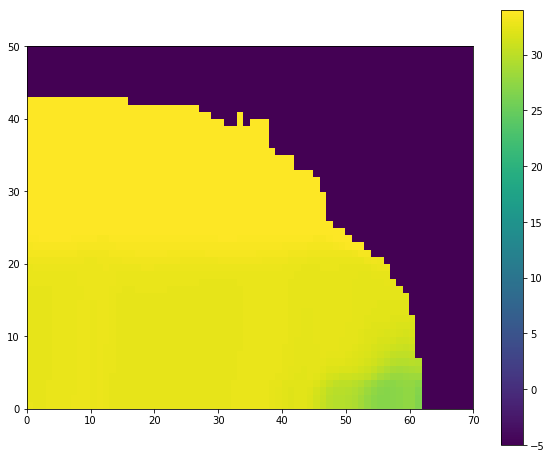

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
#cmap = plt.get_cmap('winter_r')
#cmap.set_bad('burlywood')
mesh = ax.pcolormesh(vosaline_JP_level_RS_south[0,:,3,:], vmin =-5, vmax=34)#, cmap=cmap)
fig.colorbar(mesh)

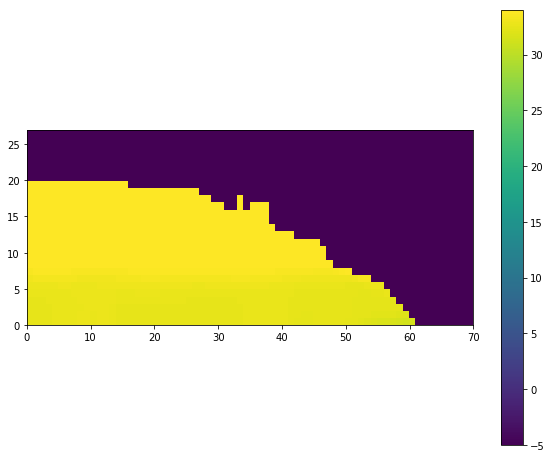

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
#cmap = plt.get_cmap('winter_r')
#cmap.set_bad('burlywood')
mesh = ax.pcolormesh(vosaline_NEMO_south[0,:,3,:], vmin =-5, vmax=34)#, cmap=cmap)
fig.colorbar(mesh)

In [21]:
# ### Cover all Nan values at the lower depth levels with values from the top level immediately above it



for i in np.arange(vosaline_NEMO_south.shape[0]):
    for j in np.arange(vosaline_NEMO_south.shape[1]):
        for k in np.arange(vosaline_NEMO_south.shape[2]):
            for l in np.arange(vosaline_NEMO_south.shape[3]):
                if np.isnan(vosaline_NEMO_south[i,j,k,l]):
                    vosaline_NEMO_south[i,j,k,l] = vosaline_NEMO_south[i,j-1,k,l]
                else:
                    continue
            

for i in np.arange(votemper_NEMO_south.shape[0]):
    for j in np.arange(votemper_NEMO_south.shape[1]):
        for k in np.arange(votemper_NEMO_south.shape[2]):
            for l in np.arange(votemper_NEMO_south.shape[3]):
                if np.isnan(votemper_NEMO_south[i,j,k,l]):
                    votemper_NEMO_south[i,j,k,l] = votemper_NEMO_south[i,j-1,k,l]
                else:
                    continue   

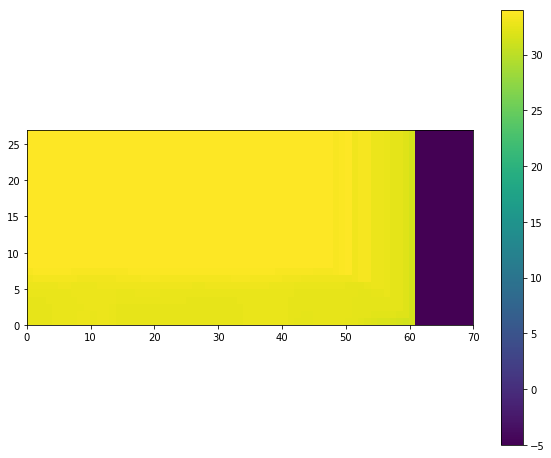

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
#cmap = plt.get_cmap('winter_r')
#cmap.set_bad('burlywood')
mesh = ax.pcolormesh(vosaline_NEMO_south[0,:,3,:], vmin =-5, vmax=34)#, cmap=cmap)
fig.colorbar(mesh)

In [25]:
print(vosaline_NEMO_south[0,:,0,0])

[ 32.61945213  32.619       32.61901521  32.62958743  32.69215381
  32.89987301  33.26127286  33.67483256  34.01168477  34.17285833
  34.21583362  34.2691515   34.39385287  34.50998288  34.60367377
  34.66467592  34.71601133  34.763388    34.79376569  34.80327475
  34.80327475  34.80327475  34.80327475  34.80327475  34.80327475
  34.80327475  34.80327475]


In [26]:
### To not have any nan values lets copy the ones that we have to the other right hand side



for i in np.arange(vosaline_NEMO_south.shape[0]):
    for j in np.arange(vosaline_NEMO_south.shape[1]):
        for k in np.arange(vosaline_NEMO_south.shape[2]):
            for l in np.arange(vosaline_NEMO_south.shape[3]):
                if np.isnan(vosaline_NEMO_south[i,j,k,l]):
                    vosaline_NEMO_south[i,j,k,l] = vosaline_NEMO_south[i,j,k,l-1]
                else:
                    continue
                    
                    
for i in np.arange(votemper_NEMO_south.shape[0]):
    for j in np.arange(votemper_NEMO_south.shape[1]):
        for k in np.arange(votemper_NEMO_south.shape[2]):
            for l in np.arange(votemper_NEMO_south.shape[3]):
                if np.isnan(votemper_NEMO_south[i,j,k,l]):
                    votemper_NEMO_south[i,j,k,l] = votemper_NEMO_south[i,j,k,l-1]
                else:
                    continue

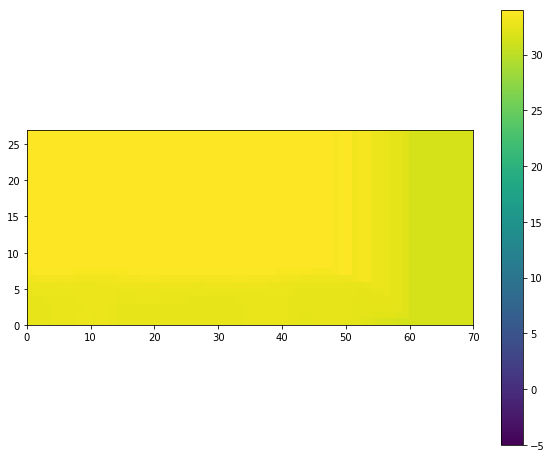

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
#cmap = plt.get_cmap('winter_r')
#cmap.set_bad('burlywood')
mesh = ax.pcolormesh(vosaline_NEMO_south[0,:,3,:], vmin =-5, vmax=34)#, cmap=cmap)
fig.colorbar(mesh)

In [84]:
np.where(np.isnan(votemper_NEMO_south[...]))

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [88]:
np.where(np.isnan(U_NEMO_right[...]))

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

for a,b in enumerate(vosaline_NEMO_south[:,...]):
    for i,j in enumerate(vosaline_NEMO_south[a,:,...]):
        for p,q in enumerate(vosaline_NEMO_south[a,i,:,...]):
            for l,m in enumerate(vosaline_NEMO_south[a,i,p,:]):
                if vosaline_NEMO_south[a,i,p,l] == 0:
                    vosaline_NEMO_south[a,i,p,l] = vosaline_NEMO_south[a,i-1,p,l]
                else:
                    continue

In [28]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# viz_tools.set_aspect(ax)
# mesh = ax.pcolormesh(vosaline_NEMO_south[0,:,3,:], vmin =30)
# fig.colorbar(mesh)


In [ ]:
# np.nanmin(vosaline_NEMO_south)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# viz_tools.set_aspect(ax)
# mesh = ax.pcolormesh(votemper_NEMO_south[0,:,3,:])
# fig.colorbar(mesh)


In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# viz_tools.set_aspect(ax)
# mesh = ax.pcolormesh(U_NEMO_south[0,:,3,:])
# fig.colorbar(mesh)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# viz_tools.set_aspect(ax)
# mesh = ax.pcolormesh(V_NEMO_south[0,:,3,:])
# fig.colorbar(mesh)

for i in [0,1,2,3,4]:
    votemper_NEMO_south[i,...] = bc_temp_south[...];
    vosaline_NEMO_south[i,...] = bc_sal_south[...];

In [29]:
#Now let us write the 3d boundary condition for the south boundary

bdy_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/3d_NEMO_south_m04.nc', 'w', zlib=True);


bdy_file.createDimension('xb', U_NEMO_south.shape[3]);
bdy_file.createDimension('yb', U_NEMO_south.shape[2]);
bdy_file.createDimension('deptht', U_NEMO_south.shape[1]);
bdy_file.createDimension('time_counter', None);


xb = bdy_file.createVariable('xb', 'int32', ('xb',), zlib=True);
xb.units = 'indices';
xb.longname = 'x indices along south boundary';

yb = bdy_file.createVariable('yb', 'int32', ('yb',), zlib=True);
yb.units = 'indices';
yb.longname = 'a strip of y indices across all of south boundary';

deptht = bdy_file.createVariable('deptht', 'float32', ('deptht',), zlib=True);
deptht.units = 'm';
deptht.longname = 'Vertical T Levels';

time_counter = bdy_file.createVariable('time_counter', 'int32', ('time_counter',), zlib=True);
time_counter.units = 's';
time_counter.longname = 'time';

vozocrtx = bdy_file.createVariable('vozocrtx', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
vomecrty = bdy_file.createVariable('vomecrty', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
votemper = bdy_file.createVariable('votemper', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
vosaline = bdy_file.createVariable('vosaline', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);

vozocrtx[:] = U_NEMO_south[:,:,:,:];
vomecrty[:] = V_NEMO_south[:,:,:,:];
votemper[:] = votemper_NEMO_south[:,:,:,:];
vosaline[:] = vosaline_NEMO_south[:,:,:,:];
deptht[:] = NEMO_depth_T[:];

#vozocrtx[:] = vozocrtx[:,:,::-1,:];### This is done because NEMO reads the file the other way around
#vomecrty[:] = vomecrty[:,:,::-1,:];
#votemper[:] = votemper[:,:,::-1,:];
#vosaline[:] = vosaline[:,:,::-1,:];


bdy_file.close()

In [ ]:
plt.plot(vosaline_NEMO_south[0,:,3,40], NEMO_depth_T)

In [ ]:
plt.plot(votemper_NEMO_south[0,:,3,39], NEMO_depth_T)

In [ ]:
plt.plot(vosaline_NEMO_south[0,:,3,35], NEMO_depth_T)

In [ ]:
vosaline_NEMO_south[0,14,3,39]

for a in range(vosaline_NEMO_south.shape[0]):
    for i in range(vosaline_NEMO_south.shape[1]):
        for p in range(vosaline_NEMO_south.shape[2]):
            for q in range(vosaline_NEMO_south.shape[3]):
                if vosaline_NEMO_south[a,i,p,q] == 0:
                    vosaline_NEMO_south[a,i,p,q] = vosaline_NEMO_south[a,np.argmin(vosaline_NEMO_south[a,:,p,q])-1,p,q]
                    #print(vosaline_NEMO_south[a,i,p,q])
                else:
                    continue

In [ ]:
np.min(vosaline_NEMO_south[0,:,3,:])

In [ ]:
np.argmin(vosaline_NEMO_south[0,:,3,40])

In [ ]:
vosaline_NEMO_south[0,:,3,40]

In [ ]:
np.nonzero(vosaline_NEMO_south[0,:,3,:])

In [ ]:
vosaline_NEMO_south[0,:,3,38]

In [ ]:
np.where(vosaline_NEMO_south[0,:,3,:] == 0)

In [ ]:
NEMO_depth_T[3]

In [ ]:
np.max(vosaline_NEMO_south[0,:,3,38]-vosaline_NEMO_south[0,:,3,40])

In [ ]:
np.argmax(vosaline_NEMO_south[0,:,3,38]-vosaline_NEMO_south[0,:,3,40])

In [ ]:
np.min(vosaline_NEMO_south[0,:,3,38]-vosaline_NEMO_south[0,:,3,40])

In [ ]:
np.argmin(vosaline_NEMO_south[0,:,3,38]-vosaline_NEMO_south[0,:,3,40])

reset_selective vosaline_NEMO_south

In [ ]:
np.min(vosaline_NEMO_south[0,:,3,40])

In [ ]:
for a in range(vosaline_NEMO_south.shape[0]):
    for i in range(4,vosaline_NEMO_south.shape[1]):
        for p in range(vosaline_NEMO_south.shape[2]):
            for q in range(vosaline_NEMO_south.shape[3]):
                if vosaline_NEMO_south[a,i,p,q] < vosaline_NEMO_south[a,i-1,p,q]:
                    vosaline_NEMO_south[a,i,p,q] = vosaline_NEMO_south[a,i-1,p,q]
                    #print(vosaline_NEMO_south[a,i,p,q])
                else:
                    continue

In [ ]:
depth_JP_T[10]

In [ ]:
NEMO_depth_T[1]